In [20]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(140)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [21]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.1:44062 Dashboard: http://172.30.100.1:33853/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [22]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8152871     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8152873     hsw24 make_pro albert7a PD       0:00      1 (Resources)
           8152874     hsw24 make_pro albert7a PD       0:00      1 (None)
           8152875     hsw24 make_pro albert7a PD       0:00      1 (None)
           8152876     hsw24 make_pro albert7a PD       0:00      1 (None)
           8152431     hsw24 make_pro albert7a  R      29:43      1 n2160
           8152432     hsw24 make_pro albert7a  R      29:43      1 n2829
           8152433     hsw24 make_pro albert7a  R      29:43      1 n2831
           8152434     hsw24 make_pro albert7a  R      29:43      1 n2832
           8152435     hsw24 make_pro albert7a  R      29:43      1 n2833
           8152436     hsw24 make_pro albert7a  R      29:43      1 n2835
           8152437     hsw24 make_pro albert7a  R      29:43      1 n2209
           81

In [23]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

27


In [24]:
import dask.array as da
import sys
import os
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


In [25]:
#params

plot_dzU_profiles=True


In [26]:
config='EU36'
case='MPC001'
freq='1d'
year='2011'

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'


In [27]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [28]:
def dz_var(data,e3,dimdep):
    inv_e3=1/e3
    if dimdep == 'deptht':
        dz_var = (data.shift(deptht=-1) - data)
    if dimdep == 'depthu':
        dz_var = (data.shift(depthu=-1) - data)
    if dimdep == 'depthv':
        dz_var = (data.shift(depthv=-1) - data)
    if dimdep == 'depthw':
        dz_var = (data.shift(depthw=-1) - data)
    return dz_var*inv_e3


In [29]:
filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m01d??.'+str(freq)+'_gridU.nc'))
filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m01d??.'+str(freq)+'_gridV.nc'))
dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':10,'depthu':1})
dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':10,'depthv':1})
u=dsU.vozocrtx
v=dsV.vomecrty
    
    


In [30]:
u_anom=u-u.mean(dim='time_counter')
v_anom=v-v.mean(dim='time_counter')
e3u=dsmask.e3u_0
e3v=dsmask.e3v_0


In [31]:
e3u_d=e3u.rename({'nav_lev':'depthu'})
e3v_d=e3v.rename({'nav_lev':'depthv'})

In [32]:
dz_u = (u_anom.shift(depthu=-1) - u_anom)
dz_v = (v_anom.shift(depthv=-1) - v_anom)

In [33]:
inv_e3u_d=1/e3u_d
inv_e3v_d=1/e3v_d

In [34]:
import dask.array as da
dask_inv_e3u=da.from_array(inv_e3u_d, chunks=(1, 1, 1000, 700))
dask_inv_e3v=da.from_array(inv_e3v_d, chunks=(1, 1, 1000, 700))


In [35]:
udz=dz_u*dask_inv_e3u
vdz=dz_v*dask_inv_e3v


In [36]:
udz2=udz*udz
vdz2=vdz*vdz


In [37]:
udz2_t=udz2.rename({'depthu':'deptht'})
vdz2_t=vdz2.rename({'depthv':'deptht'})

In [38]:
udz2vdz2sum=udz2_t+vdz2_t

In [39]:
shear=np.sqrt(udz2vdz2sum)

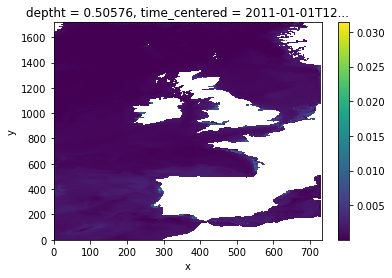

In [40]:
shear[0,0].plot()

In [42]:
shear

<xarray.DataArray (time_counter: 31, deptht: 75, y: 1718, x: 732)>
dask.array<shape=(31, 75, 1718, 732), dtype=float64, chunksize=(1, 1, 1000, 700)>
Coordinates:
  * deptht         (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(31,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2011-01-01T12:00:00 ... 2011-01-31T12:00:00
Dimensions without coordinates: y, x

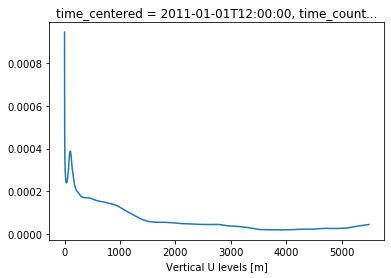

In [43]:
shear[0].mean(dim='x').mean(dim='y').plot()

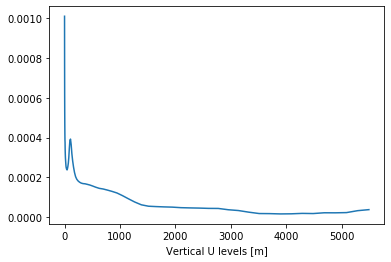

In [44]:
shear.mean(dim='time_counter').mean(dim='x').mean(dim='y').plot()